#### About

- SOTA is 90.52%: https://platform.ai/blog/page/3/new-food-101-sota-with-fastai-and-platform-ais-fast-augmentation-search/
- Other results: https://github.com/stratospark/food-101-keras


#### Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split('|')[0])

fastai: 1.0.45
pytorch: 1.0.0
python: 3.6.5 


#### Examine dataset file structure

In [15]:
# download the dataset
! mkdir -p /home/ubuntu/.fastai/data; 
! cd /home/ubuntu/.fastai/data; wget -nc https://data.mendeley.com/datasets/rscbjbr9sj/2/files/41d542e7-7f91-47f6-9ff2-dd8e5a5a7861/ChestXRay2017.zip; unzip -n -q ChestXRay2017.zip
! find /home/ubuntu/.fastai/data/chest_xray -name .DS_Store -exec rm {} \;

File ‘ChestXRay2017.zip’ already there; not retrieving.



In [3]:
path=Path('/home/ubuntu/.fastai/data/chest_xray')

In [6]:
# see what files we've got
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/chest_xray/.DS_Store'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/test'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train')]

In [7]:
Path(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/PNEUMONIA'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/.DS_Store')]

In [8]:
# show some sample paths to the images
get_image_files(path/'train/NORMAL')[:5]

[PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0545-0001-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0427-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0648-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0660-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0637-0001.jpeg')]

In [16]:
# see how many files in each category
for dirname in os.listdir(path/'train'):
    print('train', dirname, len(os.listdir(path/'train'/dirname)))
for dirname in os.listdir(path/'test'):
    print('test ', dirname, len(os.listdir(path/'test'/dirname)))

train NORMAL 1349
train PNEUMONIA 3884
test  NORMAL 234
test  PNEUMONIA 390


#### Examine image size distribution

torch.Size([3, 1580, 1924])


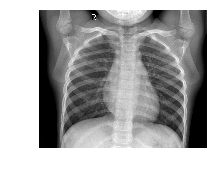

In [17]:
# look the shape and visualize one image
img = open_image(get_image_files(path/'train/NORMAL')[0])
print(img.shape)
img.show()

In [21]:
# calculate average, minimum, and maximum for width and height of images
widths, heights = [], []
width_min, width_max = np.inf, -np.inf
height_min, height_max = np.inf, -np.inf

for ds in ['train', 'test']:
    for dirname in os.listdir(path/ds):
        for filename in os.listdir(path/ds/dirname):
            image = PIL.Image.open(os.path.join(path/ds/dirname, filename))
            widths.append(image.size[0])
            heights.append(image.size[1])

print('avg (width, height): ', (np.mean(widths), np.mean(heights)))
print('std (width, height): ', (np.std(widths), np.std(heights)))
print('width (min, max): ', (np.min(widths), np.max(widths)))
print('height (min, max): ', (np.min(heights), np.max(heights)))

avg (width, height):  (1327.880806010929, 970.6890368852459)
std (width, height):  (363.46988369451225, 383.35938110959034)
width (min, max):  (384, 2916)
height (min, max):  (127, 2713)


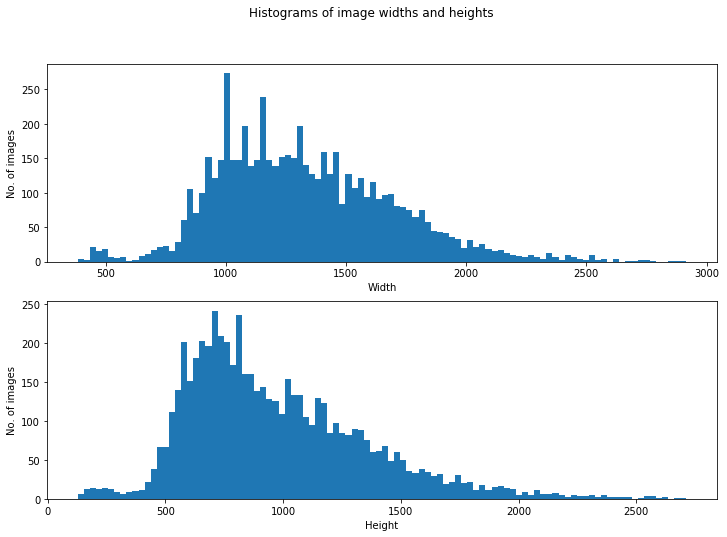

In [22]:
# plot histograms of heights and widths.
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Histograms of image widths and heights')
 
ax1.hist(widths, bins=100); ax1.set_xlabel('Width'); ax1.set_ylabel('No. of images')
ax2.hist(heights, bins=100); ax2.set_xlabel('Height'); ax2.set_ylabel('No. of images')
 
plt.show()

#### Create datablock

In [23]:
# set hyperparamters
np.random.seed(42)
size = 224
bs = 64
num_workers = 4

In [4]:
# define data augmentation transformations
tfms = get_transforms()

In [5]:
# use the labeled test data as the validation set
src = (ImageItemList.from_folder(path)
       .split_by_folder(train='train', valid='test')
       .label_from_folder())

In [26]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

#### Do sanity checks

In [27]:
# verify datasets loaded properly
print(len(data.train_ds))
print(len(data.valid_ds))

5232
624


In [28]:
data.classes

['NORMAL', 'PNEUMONIA']

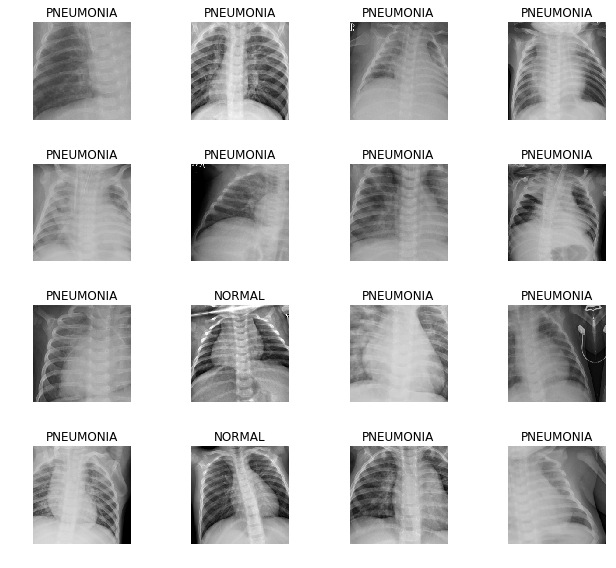

In [29]:
data.show_batch(rows=4, figsize=(9,8))

#### Create model

In [6]:
# define architecture
arch = models.resnet50

In [31]:
# create learner
learn = create_cnn(data, arch, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 70336453.48it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03


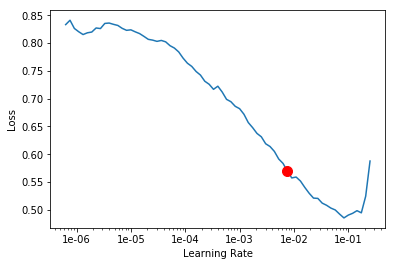

In [32]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [33]:
lr = 7.59e-3

## size 224

#### Train on frozen model

In [34]:
# first fit the head of the model
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.275451,0.398320,0.854167
2,0.170159,0.330427,0.894231
3,0.134787,0.292850,0.900641
4,0.105536,0.403626,0.875000
5,0.087345,0.310978,0.905449
6,0.069499,0.320798,0.918269
7,0.070728,0.325637,0.902244
8,0.063801,0.307066,0.911859


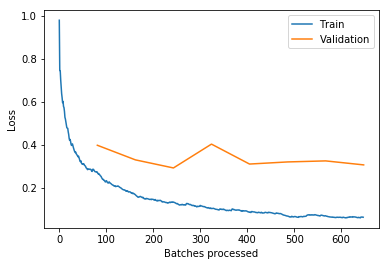

In [35]:
learn.recorder.plot_losses()

In [36]:
learn.save('stage-1')

#### Train on unfrozen model

In [37]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06


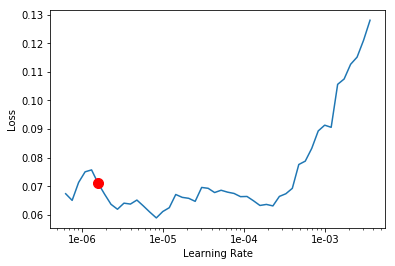

In [38]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [39]:
# now fit across the entire model
learn.fit_one_cycle(3, max_lr=slice(1.58e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.056940,0.284566,0.911859
2,0.050659,0.312302,0.910256
3,0.045632,0.278788,0.919872


In [40]:
learn.save('stage-2')

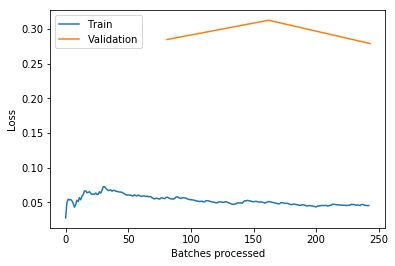

In [41]:
learn.recorder.plot_losses()

#### Look at results

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

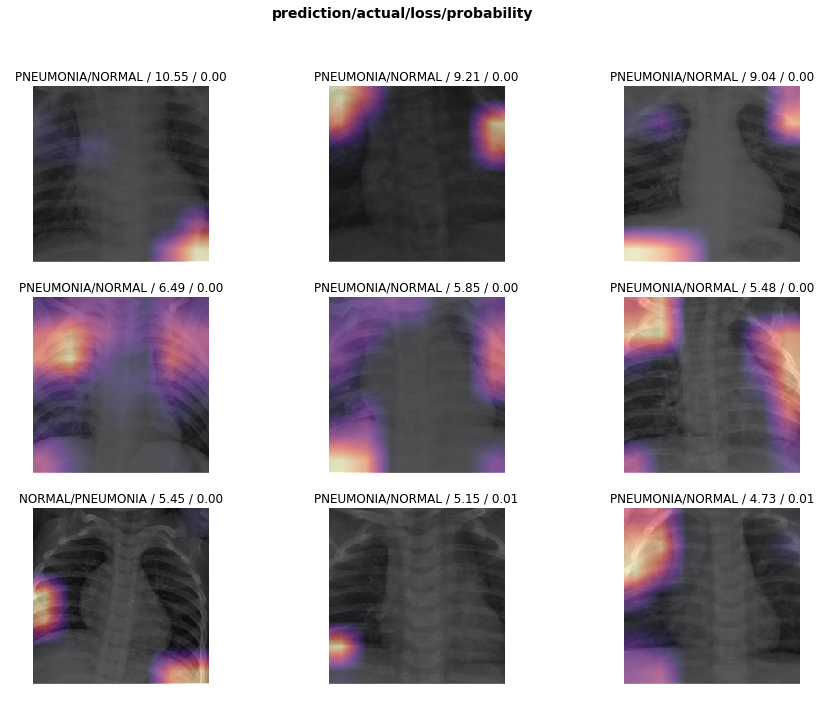

In [43]:
interp.plot_top_losses(9, figsize=(15,11))

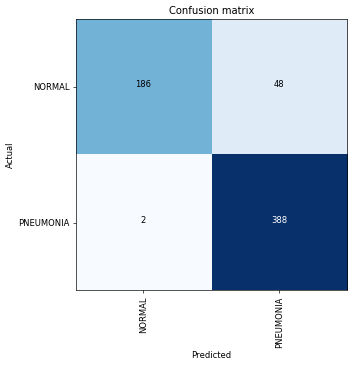

In [44]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [46]:
# print accuracy
correct_preds = interp.pred_class == interp.y_true
sum(correct_preds.numpy()) / len(correct_preds)

0.9198717948717948

In [47]:
# calculate precision and recall
(tn, fp), (fn, tp) = interp.confusion_matrix()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.8899
Recall: 0.9949


#### Look at results with TTA

In [48]:
interp_tta = ClassificationInterpretation.from_learner(learn, tta=True)
losses,idxs = interp_tta.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

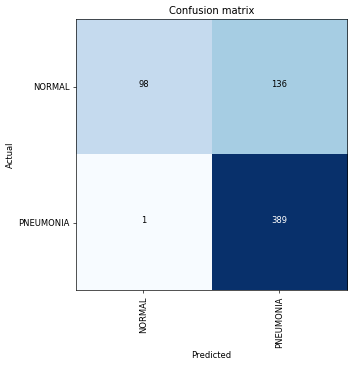

In [50]:
interp_tta.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [53]:
# print accuracy
correct_preds = interp_tta.pred_class == interp_tta.y_true
sum(correct_preds.numpy()) / len(correct_preds)

0.780448717948718

In [54]:
# calculate precision and recall
(tn, fp), (fn, tp) = interp_tta.confusion_matrix()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.7410
Recall: 0.9974


## size 512

In [7]:
# set hyperparamters
np.random.seed(42)
size = 512
bs = 24
num_workers = 4

In [8]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [9]:
learn = create_cnn(data, arch, metrics=accuracy).load('stage-2')

In [10]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06


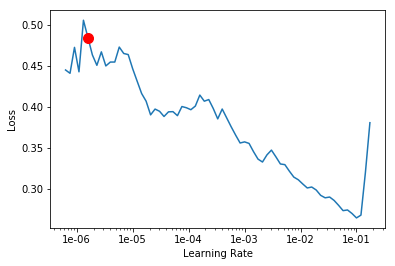

In [11]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [12]:
lr = 5e-3

#### Train on frozen model

In [13]:
# first fit the head of the model
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.118642,0.414400,0.875000
2,0.099694,0.582102,0.878205
3,0.128096,0.399491,0.871795
4,0.096826,0.346377,0.907051
5,0.067270,0.415702,0.897436
6,0.051219,0.478703,0.894231
7,0.039360,0.448910,0.902244
8,0.037191,0.446017,0.905449


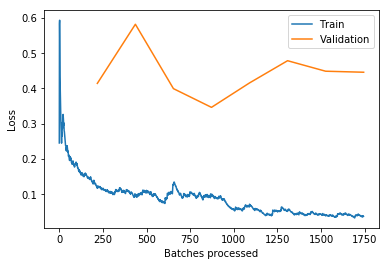

In [14]:
learn.recorder.plot_losses()

In [15]:
learn.save('stage-3')

#### Train on unfrozen model

In [16]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


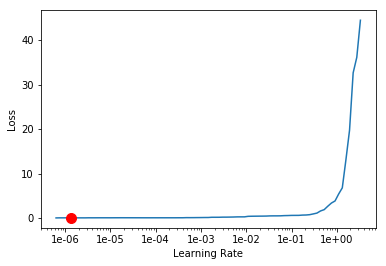

In [21]:
# find ideal learning rate
learn.lr_find(stop_div=False)
learn.recorder.plot()

In [23]:
# now fit across the entire model
learn.fit_one_cycle(3, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.102008,0.714864,0.804487
2,0.055244,0.310354,0.908654
3,0.026548,0.456951,0.879808


In [24]:
learn.save('stage-4')

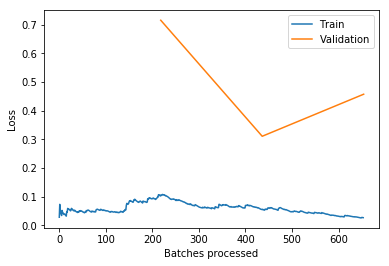

In [25]:
learn.recorder.plot_losses()

#### Look at results

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

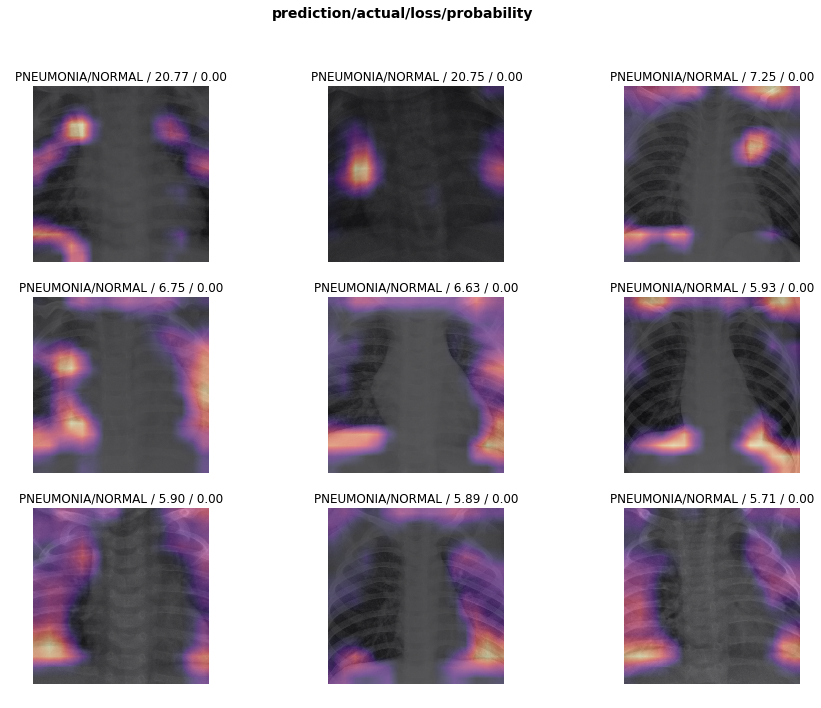

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

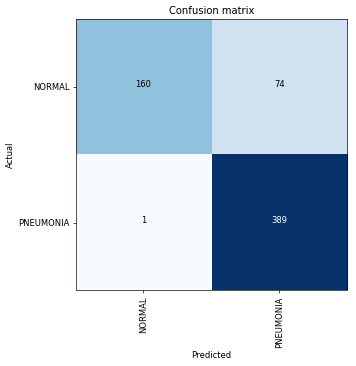

In [28]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [29]:
# print accuracy
correct_preds = interp.pred_class == interp.y_true
sum(correct_preds.numpy()) / len(correct_preds)

0.8798076923076923

In [30]:
# calculate precision and recall
(tn, fp), (fn, tp) = interp.confusion_matrix()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.8402
Recall: 0.9974


#### Look at results with TTA

In [31]:
interp_tta = ClassificationInterpretation.from_learner(learn, tta=True)
losses,idxs = interp_tta.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

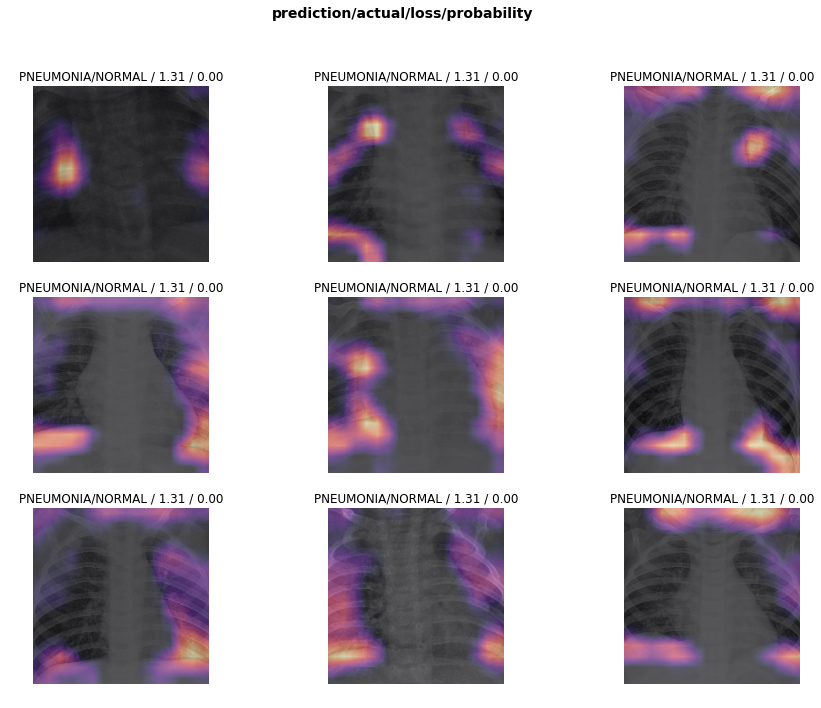

In [32]:
interp_tta.plot_top_losses(9, figsize=(15,11))

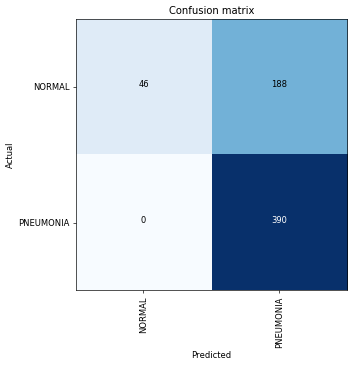

In [33]:
interp_tta.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [34]:
# print accuracy
correct_preds = interp_tta.pred_class == interp_tta.y_true
sum(correct_preds.numpy()) / len(correct_preds)

0.6987179487179487

In [35]:
# calculate precision and recall
(tn, fp), (fn, tp) = interp_tta.confusion_matrix()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.6747
Recall: 1.0000
